In [61]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf


In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


#Load Images

In [65]:
images = np.load('pathmnist.npz')

In [66]:
x_train = images['train_images']
x_val = images['val_images']
x_test = images['test_images']

y_train = images['train_labels']
y_val = images['val_labels']
y_test = images['test_labels']

In [67]:
x_train.shape

(89996, 28, 28, 3)

In [68]:
y_train.shape

(89996, 1)

In [69]:
x_train.max()

255

In [70]:
y_train.max()

8

#Preprocess Data

In [71]:
x_train = x_train/255
x_test = x_test/255
x_val = x_val/255

In [72]:
from tensorflow.keras.utils import to_categorical

In [73]:
#one hot encoding

y_cat_train = to_categorical(y_train)
y_cat_val = to_categorical(y_val)
y_cat_test = to_categorical(y_test)

In [74]:
y_cat_train.shape

(89996, 9)

In [75]:
y_cat_test.shape

(7180, 9)

#Build Model

In [77]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

In [78]:
shape = 28, 28, 3
num_classes = 9
filters = 32

# Batch normalization, ReLU, and 2D conversion function
def ConvolutionalBlock(x, filters, kernel=1, strides=1):
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(filters, kernel, strides=strides, padding = 'same')(x)

  return x

def DenseBlock(x, num_repeats):
  for _ in range(num_repeats):
    y = ConvolutionalBlock(x, 4*filters)
    y = ConvolutionalBlock(y, filters, 3)
    x = concatenate([y, x])
  return x

def TransitionLayer(x):
  x = ConvolutionalBlock(x, K.int_shape(x)[-1] //2)
  x = AvgPool2D(2, strides=2, padding='same')(x)
  return x

input = Input(shape)
x = Conv2D(64, 7, strides=2, padding='same')(input)
x = MaxPool2D(3, strides=2, padding='same')(x)

for num_repeats in [6, 12, 24, 16]:
  d = DenseBlock(x, num_repeats)
  x = TransitionLayer(d)

x = GlobalAveragePooling2D()(d)
out = Dense(num_classes, activation='softmax', kernel_regularizer='l1')(x)
#tf.keras.layers.Dropout(0.5)
model = Model(input, out)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_121 (Conv2D)            (None, 14, 14, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 7, 7, 64)    0           ['conv2d_121[0][0]']             
                                                                                                  
 batch_normalization_120 (Batch  (None, 7, 7, 64)    256         ['max_pooling2d_1[0][0]']        
 Normalization)                                                                             

#Train Model

In [79]:
from tensorflow.keras.callbacks import EarlyStopping

In [80]:
early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [81]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-05)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [82]:
model.fit(x_train, y_cat_train, batch_size=256, epochs=15, validation_data=(x_test, y_cat_test), callbacks=[early_stop])

Epoch 1/15
352/352 [==============================] - 96s 224ms/step - loss: 4.6993 - accuracy: 0.5320 - val_loss: 5.6851 - val_accuracy: 0.1744
Epoch 2/15
352/352 [==============================] - 75s 213ms/step - loss: 4.0582 - accuracy: 0.6628 - val_loss: 3.9991 - val_accuracy: 0.6604
Epoch 3/15
352/352 [==============================] - 76s 216ms/step - loss: 3.6853 - accuracy: 0.7077 - val_loss: 3.7124 - val_accuracy: 0.6855
Epoch 4/15
352/352 [==============================] - 75s 213ms/step - loss: 3.3671 - accuracy: 0.7368 - val_loss: 3.5307 - val_accuracy: 0.6708
Epoch 5/15
352/352 [==============================] - 76s 215ms/step - loss: 3.0817 - accuracy: 0.7561 - val_loss: 3.2088 - val_accuracy: 0.7146
Epoch 6/15
352/352 [==============================] - 76s 215ms/step - loss: 2.8169 - accuracy: 0.7741 - val_loss: 3.0589 - val_accuracy: 0.6801
Epoch 7/15
352/352 [==============================] - 76s 217ms/step - loss: 2.5687 - accuracy: 0.7900 - val_loss: 2.7729 - val_ac

In [83]:
metrics = pd.DataFrame(model.history.history)

In [84]:
metrics

,loss,accuracy,val_loss,val_accuracy
0,4.699340,0.531968,5.685056,0.174373
1,4.058187,0.662774,3.999144,0.660446
2,3.685256,0.707731,3.712420,0.685515
3,3.367109,0.736833,3.530670,0.670752
4,3.081733,0.756111,3.208828,0.714624
5,2.816892,0.774134,3.058876,0.680084
6,2.568741,0.790046,2.772931,0.713928
7,2.340328,0.802602,2.587569,0.714345
8,2.124712,0.817336,2.426137,0.709749
9,1.924043,0.828526,2.306981,0.699861


In [85]:
metrics.columns

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')

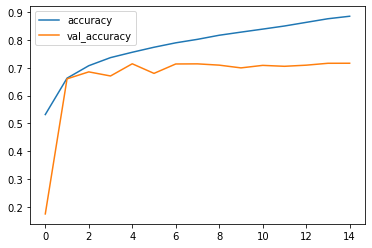

In [86]:
metrics[['accuracy', 'val_accuracy']].plot()

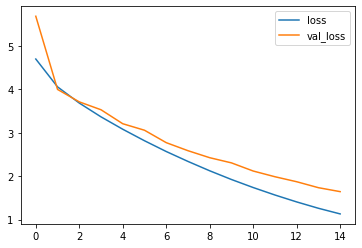

In [87]:
metrics[['loss', 'val_loss']].plot()

In [88]:
from sklearn.metrics import classification_report, confusion_matrix

In [89]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)

In [90]:
y_pred

array([8, 4, 4, ..., 4, 8, 8])

In [91]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1246
           1       1.00      0.78      0.88      1080
           2       0.68      0.39      0.50       592
           3       0.62      0.75      0.68       522
           4       0.63      0.88      0.73       744
           5       0.48      0.50      0.49       571
           6       0.62      0.58      0.60       785
           7       0.38      0.47      0.42       338
           8       0.80      0.76      0.78      1302

    accuracy                           0.72      7180
   macro avg       0.67      0.67      0.66      7180
weighted avg       0.73      0.72      0.72      7180



In [92]:
print(confusion_matrix(y_pred, y_test))

[[1133    0    0   13   91    0    8    0    1]
 [   8  847    0    1  223    0    0    0    1]
 [  22    0  231   14    0  108   49  102   66]
 [   0    0    9  392   13   58   23   12   15]
 [  27    0    0   14  652    0   29   10   12]
 [ 139    0   51    6    3  287   18   58    9]
 [   3    0    0  153   20    0  458   12  139]
 [   0    0   34    3    6  124    6  160    5]
 [   6    0   14   38   27   15  150   67  985]]


In [93]:
model.save('model_DenseNet.h5')

In [94]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, accuracy_score

In [95]:
model = tf.keras.models.load_model('model_DenseNet.h5')

In [111]:
y_pred = model.predict(x_test)

y_test_pred = y_pred
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)

In [99]:
print("ROC AUC SCORES")

print('test')
print(roc_auc_score(y_test, y_test_pred, multi_class='ovr'))
print()

print('validation')
print(roc_auc_score(y_val, y_val_pred, multi_class='ovr'))
print()

print('train')
print(roc_auc_score(y_train, y_train_pred, multi_class="ovr"))

ROC AUC SCORES
test
0.9320602904321282

validation
0.9674639510090126

train
0.992272455405637


In [100]:
print("PRC AUC SCORES")

print('test')
print(average_precision_score(y_cat_test, y_test_pred))
print()

print('validation')
print(average_precision_score(y_cat_val, y_val_pred))
print()

print('train')
print(average_precision_score(y_cat_train, y_train_pred))

PRC AUC SCORES
test
0.6994421538110984

validation
0.832938517646612

train
0.9536486170689342


In [112]:
print(y_pred)
y_pred = np.argmax(y_pred, axis=1)
y_test_pred = y_pred
y_train_pred = np.argmax(y_train_pred, axis=1)
print(y_train_pred.shape)
y_val_pred = np.argmax(y_val_pred, axis=1)

[[3.38783895e-04 7.80920614e-04 2.88002123e-03 ... 6.57252455e-03
  1.28557556e-03 9.85119402e-01]
 [5.80768008e-03 1.65574476e-02 2.73884181e-03 ... 1.32652879e-01
  5.66726224e-03 1.14687718e-02]
 [6.90872297e-02 2.46628132e-02 3.07853776e-03 ... 2.45933570e-02
  3.66270286e-03 1.06440904e-02]
 ...
 [8.32057744e-03 1.96110569e-02 8.47163331e-03 ... 8.23126733e-02
  4.99288812e-02 1.87784899e-02]
 [1.24588876e-03 1.71899935e-03 1.40625285e-02 ... 4.27510589e-03
  2.68599158e-03 9.69677567e-01]
 [1.36208080e-04 2.96862447e-04 6.81057340e-04 ... 1.86370488e-03
  4.52986365e-04 9.95120823e-01]]
(89996,)


In [113]:
print("Accuracy")
print("test")
print(accuracy_score(y_test, y_test_pred))
print()

print('validation')
print(accuracy_score(y_val, y_val_pred))
print()

print('train')
print(accuracy_score(y_train, y_train_pred))
print()

Accuracy
test
0.7165738161559888

validation
0.7745901639344263

train
0.8959064847326548

